In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import numpy.linalg as la
from numpy import loadtxt
import h5py
import pandas as pd
from mpl_toolkits.axes_grid1 import make_axes_locatable
from time import time

from tqdm import tqdm_notebook as tqdm
import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import f1_score
import pickle

In [3]:
path = "/media/DOCUMENTOS/Backups/Data"

In [4]:
def NumberConnections(Max,a,b): #Compute the ID, number of connections, and the connections
    pbar = tqdm(total = Max, desc = "Computing Connections")
    ID = np.zeros(Max)
    Nc = np.zeros(Max)
    Connections=[]
    for n in range(Max):
        kx = b[(a == n)]
        ky = a[(b == n)]
        ID[n] = n
        Nc[n] = len(kx)+len(ky)
        Connections.append(np.concatenate( [kx,ky], axis=0))
        pbar.update()
    pbar.close()
    return ID.astype(int), Nc.astype(int), np.array(Connections)

def DP(x1,y1,z1,x2,y2,z2):  #Compute the distance between two points
    return np.sqrt((x1-x2)**2+(y1-y2)**2+(z1-z2)**2)

def Eigen(A):# Return the eigenvalues of a Matrix
    w,v=la.eig(A)
    w[(w<0)]=0.0001   # To fix eigenvalues -10**-26
    return w

def Volume(a,b,c):# Compute the volume using the values, a,b,c
    v=a*b*c
    if v<=0:
        v=0.0001  # To fix densisty inf
    return v

def AvD(D):       # Compute the average distance between connections
    if len(D)==0:
        return 0.0001
    else:
        return sum(D)/len(D)

def Features(Max,ID,x,y,z,con): #Return the values of average distance and a,b,c values
    #------------ Nodes
    ad = np.zeros(Max)
    a = np.zeros(Max)
    b = np.zeros(Max)
    c = np.zeros(Max)
    vol = np.zeros(Max)
    den = np.zeros(Max)
    IDnn = ID[nc != 0]
    pbar = tqdm(total=len(IDnn), desc="Computing Features")
    for n in IDnn:
        Ixx = 0
        Iyy = 0
        Izz = 0
        Ixy = 0
        Iyz = 0
        Ixz = 0
        nn = len(con[n])+1
        dist_temp = 0
        for i in con[n]:
            dist_temp = dist_temp+DP(x[n],y[n],z[n],x[i],y[i],z[i])
            Ixx = Ixx+(y[i]-y[n])**2+(z[i]-z[n])**2
            Iyy = Iyy+(z[i]-z[n])**2+(x[i]-x[n])**2
            Izz = Izz+(x[i]-x[n])**2+(y[i]-y[n])**2
            Ixy = Ixy-(x[i]-x[n])*(y[i]-y[n])
            Iyz = Iyz-(y[i]-y[n])*(z[i]-z[n])
            Ixz = Ixz-(x[i]-x[n])*(z[i]-z[n])
        pbar.update(1)
        
        ad[n] = dist_temp/nc[n]
        A = np.array([[Ixx,Ixy,Ixz],[Ixy,Iyy,Iyz],[Ixz,Iyz,Izz]])
        eig = Eigen(A)
        eig = np.sort(eig)[::-1]# Major -> Minor
        a[n] = np.sqrt(eig[0]).real #.real
        b[n] = np.sqrt(eig[1]).real
        c[n] = np.sqrt(eig[2]).real
        vol[n] = Volume(a[n],b[n],c[n])
        den[n] = 1/vol[n]
    pbar.close()
    return ad,vol,den

def neigh_features(Max,ID,nc,ncn,ad,den,con): #Compute all properties for first neighbors (Gradient)
    nc_n = np.zeros(Max)
    ad_n = np.zeros(Max)
    den_n = np.zeros(Max)
    IDnn = ID[( nc != 0 )]
    kk = 0
    pbar = tqdm(total = len(IDnn), desc = "Computing Delta Features")
    for i in IDnn:
        nc_temp = 0.0
        ad_temp = 0.0
        den_temp = 0.0
        for j in con[i]:
            nc_temp = nc_temp + ncn[j]
            ad_temp = ad_temp + ad[j]
            den_temp = den_temp + den[j]
        nc_n[i] = nc_temp/(1.0*nc[i])
        ad_n[i] = ad_temp/(1.0*nc[i])
        den_n[i] = den_temp/(1.0*nc[i])
        kk = kk + 1
        pbar.update(1)        
    pbar.close()
    nc_n = nc_n - ncn
    ad_n = ad_n - ad
    den_n = den_n - den
    return nc_n, ad_n, den_n

In [8]:
#----------------- Reading mock file to extract the r filter magnitud values
filename = './Results/example_mock_test2.hdf5' # lth0.1 because we only need the r_abs that is the same in all mock files
print(filename)
f = h5py.File(filename, 'r')
x = np.array(f['x'])
y = np.array(f['y'])
z = np.array(f['z'])
f.close()

pos_file = "example_pos_mock_test.txt"
np.savetxt(path + pos_file, np.c_[x,y,z])

#----------------- Computing beta-skeleton with Filipo code
print(path+'/bsk_data/LSSCode/bin/LSS_BSK_calc')
if os.path.isfile(path+'/bsk_data/LSSCode/bin/LSS_BSK_calc'):
    print("Computing BSK for Beta=1.0")
    command = 'sh run_BSK.sh '+path+"/bsk_data/TNG/"+pos_file+' '+pos_file[:-4]+' 1.0'
    print (command)
    os.system(command)
    print("BSK completed! \n "+pos_file[:-4]+".BSKIndex created!")

    #----------------- Reading files with beta-skeleton results
    betafile = pos_file[:-4]+".BSKIndex"
    ca, cb = loadtxt(path+'/bsk_data/TNG/'+betafile, unpack = True)
    x,y,z = loadtxt(path+'/bsk_data/TNG/'+pos_file, unpack = True)
    ca = ca.astype(int)
    cb = cb.astype(int)

    #----------------- Computing all features form b-skeleton
    Max = len(x)
    ID,nc,con = NumberConnections(Max,ca,cb)

    ad,vol,den = Features(Max,ID,x,y,z,con)

    #----------------- New definitons of ad,nc, den
    ad = ad/np.mean(ad)    
    ncn = nc.astype(float)-np.median(nc.astype(float))
    den = np.log(den)

    Dnc, Dad, Dden = neigh_features(Max,ID,nc,ncn,ad,den,con)

    #----------------- Saving all data in a hdf5 file
    f = h5py.File(path+'/bsk_data/TNG/example_features_test.hdf5','w')
    dt = h5py.special_dtype(vlen=np.dtype('int64'))
    f.create_dataset('con', (len(con),), dtype=dt)
    f['con'][...] = con
    f.create_dataset('ID', data = ID)
    f.create_dataset('coor', data = (x,y,z))
    f.create_dataset('nc', data = ncn)
    f.create_dataset('ad', data = ad)
    f.create_dataset('vol', data = vol)
    f.create_dataset('den', data = den)
    f.create_dataset('Dnc', data = Dnc)
    f.create_dataset('Dad', data = Dad)
    f.create_dataset('Dden', data = Dden)
    f.close()
    print("Catalog creation finished!")
else:
    print("Error: First run the makefile in LSSCode/src/")

./Results/example_mock_test2.hdf5
/media/DOCUMENTOS/Backups/Data/bsk_data/LSSCode/bin/LSS_BSK_calc
Computing BSK for Beta=1.0
sh run_BSK.sh /media/DOCUMENTOS/Backups/Data/bsk_data/TNG/example_pos_mock_test.txt example_pos_mock_test 1.0
BSK completed! 
 example_pos_mock_test.BSKIndex created!



Catalog creation finished!


In [9]:
#------------ Reading Bsk features catalog
filename = path+'/bsk_data/TNG/example_features_test.hdf5' # Filename with the features for the model
f = h5py.File(filename, 'r')
headers = list(f.keys())
print(headers)
ID = np.array(f['ID'])
nc = np.array(f['nc'])
ad = np.array(f['ad'])
den = np.array(f['den'])
Dnc = np.array(f['Dnc'])
Dad = np.array(f['Dad'])
Dden = np.array(f['Dden'])
f.close()

#------------ Reading the mock catalog to extract the positions   
filename = path+'/bsk_data/TNG/example_mock_test.hdf5'
f = h5py.File(filename, 'r')
headers=list(f.keys())
print(headers)
x = np.array(f['x'])
y = np.array(f['y']) 
z = np.array(f['z'])
env = np.array(f['environment'])
f.close()
       
#------------ Defining the features space 
X_valid = pd.DataFrame({'nc':nc,'ad':ad,'den':den,'Dnc':Dnc,'Dad':Dad,'Dden':Dden}) #
Pos_valid = pd.DataFrame({'x':x,'y':y,'z':z}) #
Y_valid = env

['Dad', 'Dden', 'Dnc', 'ID', 'ad', 'con', 'coor', 'den', 'nc', 'vol']
['environment', 'x', 'y', 'z']


28778 25.4
57198 50.5
25280 22.3
2105 1.9


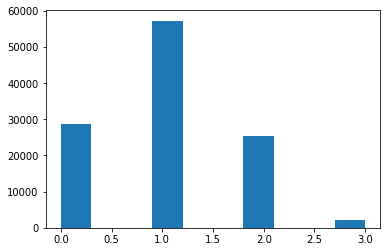

In [10]:
_ = plt.hist(np.array(env))
for i in range(4):
    portion = float(sum(np.array(env)==i)/len(np.array(env))*100)
    print(sum(np.array(env)==i), round(portion,1))

In [11]:
NLoops = 10
D = int(np.shape(X_valid)[0]/NLoops)

In [12]:
xx_pred_void = []
xx_pred_fila = []
xx_pred_peak = []
xx_pred_sheet = []

xx_valid_void = []
xx_valid_fila = []
xx_valid_peak = []
xx_valid_sheet = []

yy_pred_void = []
yy_pred_fila = []
yy_pred_peak = []
yy_pred_sheet = []

yy_valid_void = []
yy_valid_fila = []
yy_valid_peak = []
yy_valid_sheet = []


clf = pickle.load(open('./Results/cosmicweb_bsk_model.sav','rb'))
Yy_pred = clf.predict(X_valid)

total_galaxies = len(Y_valid)
total_pred_peak = 0
total_pred_fila = 0
total_pred_sheet = 0
total_pred_void = 0

total_valid_peak = 0
total_valid_fila = 0
total_valid_sheet = 0
total_valid_void = 0

correct_total = 0
correct_peak = 0
correct_fila = 0
correct_sheet = 0
correct_void = 0


for i in range(NLoops):
    Xx_valid = X_valid[i*D:(i+1)*D]
    Yy_valid = Y_valid[i*D:(i+1)*D]
    pos_valid = Pos_valid[i*D:(i+1)*D]
    Yy_pred = clf.predict(Xx_valid)
    
    total_pred_peak += sum(Yy_pred==0)
    total_pred_fila += sum(Yy_pred==1)
    total_pred_sheet += sum(Yy_pred==2)
    total_pred_void += sum(Yy_pred==3)
    
    total_valid_peak += sum(Yy_valid==0)
    total_valid_fila += sum(Yy_valid==1)
    total_valid_sheet += sum(Yy_valid==2)
    total_valid_void += sum(Yy_valid==3)
    
    correct_total += sum(Yy_pred==Yy_valid)
    correct_peak += sum( (Yy_pred==Yy_valid) & (Yy_valid==0))
    correct_fila += sum( (Yy_pred==Yy_valid) & (Yy_valid==1))
    correct_sheet += sum( (Yy_pred==Yy_valid) & (Yy_valid==2))
    correct_void += sum( (Yy_pred==Yy_valid) & (Yy_valid==3))
    
    
    zlim = 50
        
    if np.sum((Yy_pred==3) & (np.array(pos_valid['z'])<zlim)) != 0:
        xx_pred_void.append(np.array(pos_valid['x'])[(Yy_pred==3) & (np.array(pos_valid['z'])<zlim)])
        yy_pred_void.append(np.array(pos_valid['y'])[(Yy_pred==3) & (np.array(pos_valid['z'])<zlim)] )
    
    if np.sum((Yy_pred==2) & (np.array(pos_valid['z'])<zlim)) != 0:
        xx_pred_sheet.append(np.array(pos_valid['x'])[(Yy_pred==2) & (np.array(pos_valid['z'])<zlim)])
        yy_pred_sheet.append(np.array(pos_valid['y'])[(Yy_pred==2) & (np.array(pos_valid['z'])<zlim)])      
        
    if np.sum((Yy_pred==1) & (np.array(pos_valid['z'])<zlim) ) != 0:
        xx_pred_fila.append(np.array(pos_valid['x'])[(Yy_pred==1) & (np.array(pos_valid['z'])<zlim)])
        yy_pred_fila.append(np.array(pos_valid['y'])[(Yy_pred==1) & (np.array(pos_valid['z'])<zlim)])
        
    if np.sum((Yy_pred==0) & (np.array(pos_valid['z'])<zlim)) !=0:
        xx_pred_peak.append(np.array(pos_valid['x'])[(Yy_pred==0) & (np.array(pos_valid['z'])<zlim)])
        yy_pred_peak.append(np.array(pos_valid['y'])[(Yy_pred==0) & (np.array(pos_valid['z'])<zlim)])

    if np.sum((Yy_valid ==3) & (np.array(pos_valid['z'])<zlim)) != 0:
        xx_valid_void.append(np.array(pos_valid['x'])[(Yy_valid ==3) & (np.array(pos_valid['z'])<zlim)])
        yy_valid_void.append(np.array(pos_valid['y'])[(Yy_valid ==3) & (np.array(pos_valid['z'])<zlim)])       
        
    if np.sum((Yy_valid ==2) & (np.array(pos_valid['z'])<zlim)) != 0:
        xx_valid_sheet.append(np.array(pos_valid['x'])[(Yy_valid ==2) & (np.array(pos_valid['z'])<zlim)])
        yy_valid_sheet.append(np.array(pos_valid['y'])[(Yy_valid ==2) & (np.array(pos_valid['z'])<zlim)])   

    if np.sum((Yy_valid ==1) & (np.array(pos_valid['z'])<zlim)) != 0:
        xx_valid_fila.append(np.array(pos_valid['x'])[(Yy_valid ==1) & (np.array(pos_valid['z'])<zlim)])
        yy_valid_fila.append(np.array(pos_valid['y'])[(Yy_valid ==1) & (np.array(pos_valid['z'])<zlim)])
        
    if np.sum((Yy_valid ==0) & (np.array(pos_valid['z'])<zlim)) != 0:
        xx_valid_peak.append(np.array(pos_valid['x'])[(Yy_valid ==0) & (np.array(pos_valid['z'])<zlim)])
        yy_valid_peak.append(np.array(pos_valid['y'])[(Yy_valid ==0) & (np.array(pos_valid['z'])<zlim)])

In [13]:
xx_pred_void = np.concatenate(xx_pred_void).flatten()
xx_pred_fila = np.concatenate(xx_pred_fila).flatten()
xx_pred_peak = np.concatenate(xx_pred_peak).flatten()
xx_pred_sheet = np.concatenate(xx_pred_sheet).flatten()

xx_valid_void = np.concatenate(xx_valid_void).flatten()
xx_valid_fila = np.concatenate(xx_valid_fila).flatten()
xx_valid_peak = np.concatenate(xx_valid_peak).flatten()
xx_valid_sheet = np.concatenate(xx_valid_sheet).flatten()

yy_pred_void = np.concatenate(yy_pred_void).flatten()
yy_pred_fila = np.concatenate(yy_pred_fila).flatten()
yy_pred_peak = np.concatenate(yy_pred_peak).flatten()
yy_pred_sheet = np.concatenate(yy_pred_sheet).flatten()

yy_valid_void = np.concatenate(yy_valid_void).flatten()
yy_valid_fila = np.concatenate(yy_valid_fila).flatten()
yy_valid_peak = np.concatenate(yy_valid_peak).flatten()
yy_valid_sheet = np.concatenate(yy_valid_sheet).flatten()

In [14]:
ii = (xx_pred_void > min(x)+5) & (xx_pred_void < max(x)-5) & (yy_pred_void > min(y)+5 ) & (yy_pred_void < max(y)-5)
xx_pred_void = xx_pred_void[ii]
yy_pred_void = yy_pred_void[ii]

ii = (xx_pred_fila > min(x)+5) & (xx_pred_fila < max(x)-5) & (yy_pred_fila > min(y)+5) & (yy_pred_fila < max(y)-5)
xx_pred_fila = xx_pred_fila[ii]
yy_pred_fila = yy_pred_fila[ii]

ii = (xx_pred_peak > min(x)+5) & (xx_pred_peak < max(x)-5) & (yy_pred_peak > min(y)+5) & (yy_pred_peak < max(y)-5)
xx_pred_peak = xx_pred_peak[ii]
yy_pred_peak = yy_pred_peak[ii]

ii = (xx_pred_sheet > min(x)+5) & (xx_pred_sheet < max(x)-5) & (yy_pred_sheet > min(y)+5) & (yy_pred_sheet < max(y)-5)
xx_pred_sheet = xx_pred_sheet[ii]
yy_pred_sheet = yy_pred_sheet[ii]

ii = (xx_valid_void > min(x)+5) & (xx_valid_void < max(x)-5) & (yy_valid_void > min(y)+5) & (yy_valid_void < max(y)-5)
xx_valid_void = xx_valid_void[ii]
yy_valid_void = yy_valid_void[ii]

ii = (xx_valid_fila > min(x)+5) & (xx_valid_fila < max(x)-5) & (yy_valid_fila > min(y)+5) & (yy_valid_fila < max(y)-5)
xx_valid_fila = xx_valid_fila[ii]
yy_valid_fila = yy_valid_fila[ii]

ii = (xx_valid_peak > min(x)+5) & (xx_valid_peak < max(x)-5) & (yy_valid_peak > min(y)+5) & (yy_valid_peak < max(y)-5)
xx_valid_peak = xx_valid_peak[ii]
yy_valid_peak = yy_valid_peak[ii]

ii = (xx_valid_sheet > min(x)+5) & (xx_valid_sheet < max(x)-5) & (yy_valid_sheet > min(y)+5) & (yy_valid_sheet < max(y)-5)
xx_valid_sheet = xx_valid_sheet[ii]
yy_valid_sheet = yy_valid_sheet[ii]

In [15]:
Yyy = [yy_pred_sheet,yy_pred_void,yy_valid_sheet,yy_valid_void,yy_pred_fila,yy_pred_peak,yy_valid_fila,yy_valid_peak]
Xxx = [xx_pred_sheet,xx_pred_void,xx_valid_sheet,xx_valid_void,xx_pred_fila,xx_pred_peak,xx_valid_fila,xx_valid_peak]
cc = ['green','black','green','black','orange','red','orange','red']
ENV = ['Sheet','Void','Sheet','Void','Filament','Peak','Filament','Peak']

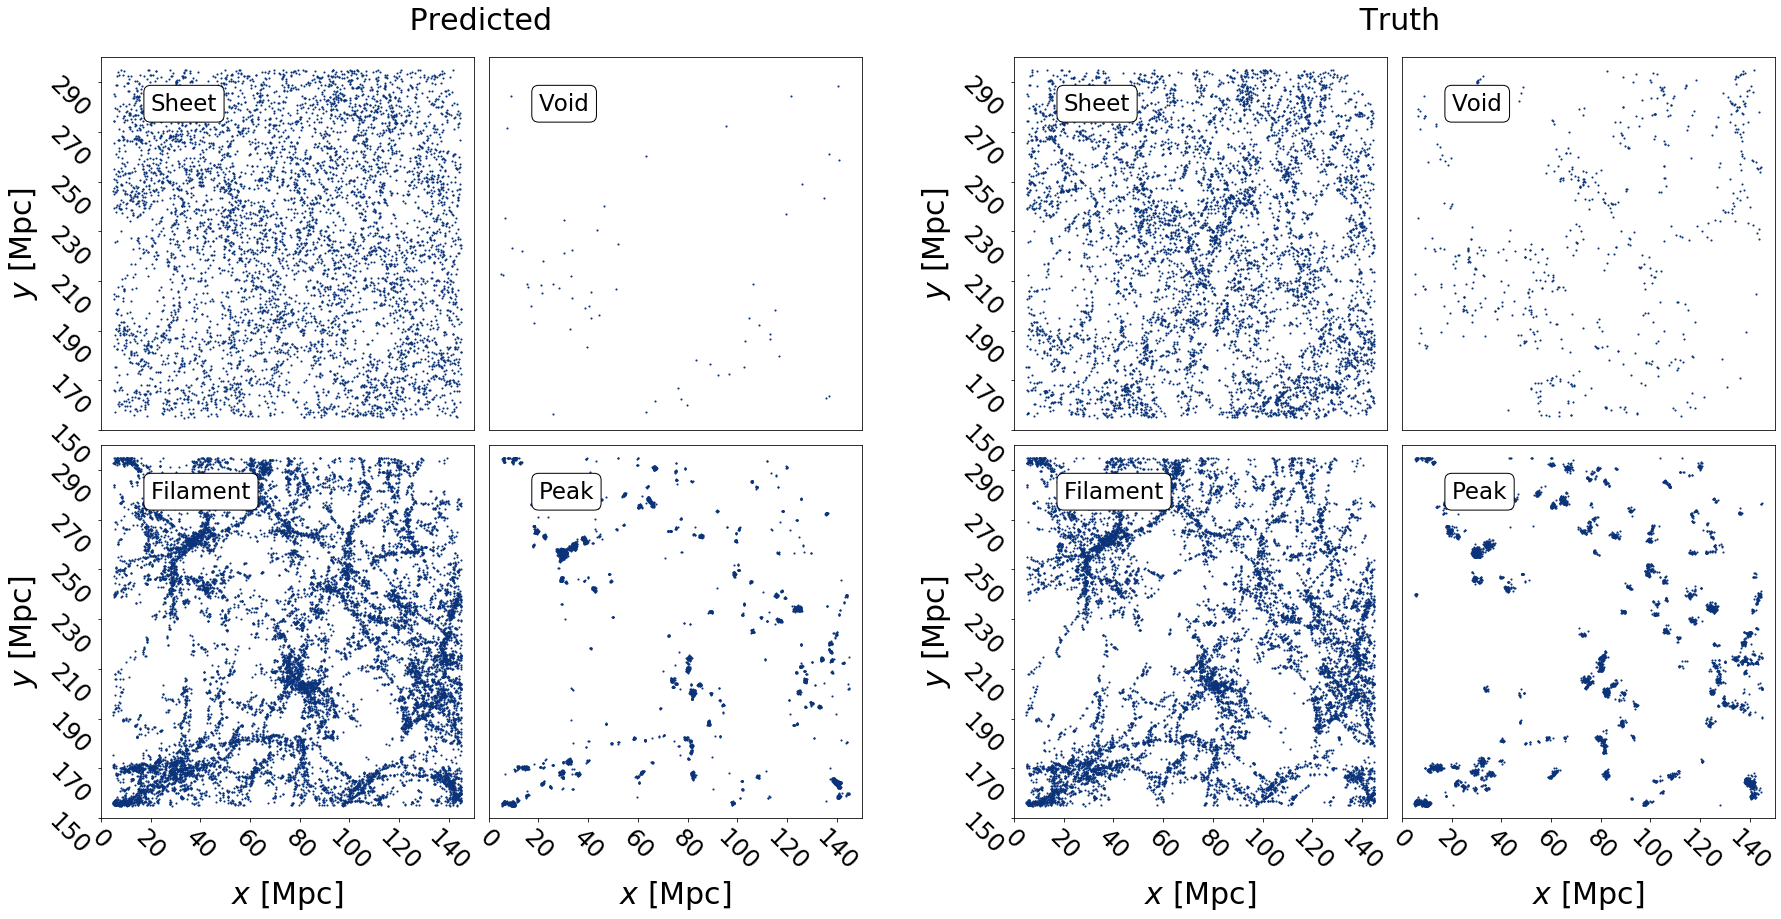

In [16]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(30, 14))
outer = gridspec.GridSpec(2, 2, wspace=0.2, hspace=0.04)

ss =  1.2
ii = 0

for i in range(4):
    inner = gridspec.GridSpecFromSubplotSpec(1,2,
                    subplot_spec=outer[i], wspace=0.04, hspace=0.04)
    
    
    for j in range(2):
        ax = plt.Subplot(fig, inner[j])
        ax.scatter(Xxx[ii],Yyy[ii],s=ss, c='#0a337a', rasterized=True)
        ax.set_xlabel("$x$ [Mpc]",size=30)
        ax.set_ylabel("$y$ [Mpc]",size=30)
        ax.set_xlim(np.min(x),np.max(x))
        ax.set_ylim(np.min(y),np.max(y))
        ax.tick_params(axis='both', labelsize=24)
        ax.xaxis.set_ticks(np.arange(min(x),max(x), 20))
        ax.yaxis.set_ticks(np.arange(min(y),max(y), 20))
        plt.setp( ax.xaxis.get_majorticklabels(), rotation=-45 )
        plt.setp( ax.yaxis.get_majorticklabels(), rotation=-45 )
        ax.annotate(ENV[ii], xy=(50, 320), xycoords='axes points',
            size=23,bbox=dict(boxstyle='round', fc='w'))
        
        fig.add_subplot(ax)
        if (ii == 1) or (ii == 3) or (ii == 5) or (ii == 7):
            plt.setp(ax.get_yaxis(), visible=False)
            plt.setp(ax.get_yticklabels(), visible=False)
        if (ii == 0) or (ii == 1) or (ii == 2) or (ii == 3):
            plt.setp(ax.get_xaxis(), visible=False)
            plt.setp(ax.get_xticklabels(), visible=False)
        
        ii += 1
        

plt.suptitle(r'   Predicted                                                                                     Truth',y=0.93,size=30)
plt.savefig("../Figures/TNG/p_environment_predicted.png", bbox_inches='tight', resterized=True, transparent=True, pad_inches = 0)
plt.savefig("../Figures/TNG/p_environment_predicted.pdf", bbox_inches='tight', resterized=True, transparent=True, pad_inches = 0)          
fig.show()

In [17]:
print(total_galaxies)
print("Real")
print(total_valid_peak,round(total_valid_peak/total_galaxies*100,1))
print(total_valid_fila,round(total_valid_fila/total_galaxies*100,1))
print(total_valid_sheet,round(total_valid_sheet/total_galaxies*100,1))
print(total_valid_void,round(total_valid_void/total_galaxies*100,1))
print(total_valid_fila+total_valid_void+total_valid_peak+total_valid_sheet)
print("\n Predictions")
print(total_pred_peak,round(total_pred_peak/total_galaxies*100,1))
print(total_pred_fila,round(total_pred_fila/total_galaxies*100,1))
print(total_pred_sheet,round(total_pred_sheet/total_galaxies*100,1))
print(total_pred_void,round(total_pred_void/total_galaxies*100,1))
print(total_pred_fila+total_pred_void+total_pred_peak+total_pred_sheet)
print("\n Correct Predictions")
print(correct_total,correct_total/total_galaxies*100)
print(correct_peak,correct_peak/total_valid_peak*100)
print(correct_fila,correct_fila/total_valid_fila*100)
print(correct_sheet,correct_sheet/total_valid_sheet*100)
print(correct_void,correct_void/total_valid_void*100)

113361
Real
28777 25.4
57198 50.5
25280 22.3
2105 1.9
113360

 Predictions
23091 20.4
68826 60.7
21288 18.8
155 0.1
113360

 Correct Predictions
78723 69.44451795591077
17973 62.456128157903876
46711 81.66544284765202
13937 55.13053797468355
102 4.845605700712589


In [18]:
mass_pred_sheet
MASS_PRED = [np.log10(mass_pred_sheet)+10,np.log10(mass_pred_void)+10,np.log10(mass_pred_fila)+10,np.log10(mass_pred_peak)+10]
MASS_VALID = [np.log10(mass_valid_sheet)+10,np.log10(mass_valid_void)+10,np.log10(mass_valid_fila)+10,np.log10(mass_valid_peak)+10]
cc = ['green','black','orange','red']
ENV = ['Sheets','Voids','Filaments','Peaks']

NameError: name 'mass_pred_sheet' is not defined

In [ ]:
fig = plt.figure(figsize=(15, 12))
outer = gridspec.GridSpec(2, 2, wspace=0.25, hspace=0.25)

ss =  1
ii = 0

for i in range(4):
    inner = gridspec.GridSpecFromSubplotSpec(1,1,
                    subplot_spec=outer[i], wspace=0.18, hspace=0.25)
    
    
    for j in range(1):
        ax = plt.Subplot(fig, inner[j])
        ax.hist(MASS_PRED[ii],rasterized=True, histtype='step',label=" Predicted",bins=np.linspace(7.0,15.0,20),linewidth=2.5)
        ax.hist(MASS_VALID[ii],ls='--', rasterized=True, histtype='step', label=" Truth",bins=np.linspace(7.0,15.0,20),linewidth=2.5)
        ax.set_xlabel(r'Log Mass [$M_{\odot}/h]$',size=25)
        ax.set_ylabel("Counts",size=25)
        ax.set_title(ENV[ii],size=25)
        ax.tick_params(axis='both', labelsize=24)
        ax.set_yscale('log')
        ax.set_xlim(7,15)
        ax.legend(fontsize=15,loc=2)
        plt.setp( ax.xaxis.get_majorticklabels(), rotation=0 )
        plt.setp( ax.yaxis.get_majorticklabels(), rotation=0 )
        
        fig.add_subplot(ax)
        if (ii == 1) or (ii == 3):
            ax.set_ylabel("",size=30)
            plt.setp(ax.get_yticklabels(), visible=True)
        if (ii == 0) or (ii == 1) :
            ax.set_xlabel("",size=30)
            
        if (ii == 3):
            ax.legend(fontsize=15,loc=1)
                    
        ii += 1
        

plt.savefig("../Figures/TNG/p_mass_predicted.png", bbox_tight=True, resterized=True, transparent=True)
plt.savefig("../Figures/TNG/p_mass_predicted.pdf", bbox_tight=True, resterized=True, transparent=True)          
fig.show()

In [ ]:
MAG_PRED = [mag_pred_sheet,mag_pred_void,mag_pred_fila,mag_pred_peak]
MAG_VALID = [mag_valid_sheet,mag_valid_void,mag_valid_fila,mag_valid_peak]
cc = ['green','black','orange','red']
ENV = ['Sheets','Voids','Filaments','Peaks']

In [ ]:
fig = plt.figure(figsize=(15, 12))
outer = gridspec.GridSpec(2, 2, wspace=0.25, hspace=0.25)

ss =  1
ii = 0

for i in range(4):
    inner = gridspec.GridSpecFromSubplotSpec(1,1,
                    subplot_spec=outer[i], wspace=0.18, hspace=0.25)
    
    
    for j in range(1):
        ax = plt.Subplot(fig, inner[j])
        ax.hist(MAG_PRED[ii],rasterized=True, histtype='step',label=" Predicted",linewidth=2.5)
        ax.hist(MAG_VALID[ii],ls='--', rasterized=True, histtype='step', label=" Truth",linewidth=2.5)
        ax.set_xlabel(r'$M_g - M_r$ [mag]',size=25)
        ax.set_ylabel("Counts",size=25)
        ax.set_title(ENV[ii],size=25)
        ax.tick_params(axis='both', labelsize=24)
        ax.set_yscale('log')
        ax.set_ylim(0,5*10**4)
        ax.legend(fontsize=15,loc=2)
        plt.setp( ax.xaxis.get_majorticklabels(), rotation=0 )
        plt.setp( ax.yaxis.get_majorticklabels(), rotation=0 )
        
        fig.add_subplot(ax)
        if (ii == 1) or (ii == 3):
            ax.set_ylabel("",size=30)
            plt.setp(ax.get_yticklabels(), visible=True)
        if (ii == 0) or (ii == 1) :
            ax.set_xlabel("",size=30)
                    
        ii += 1
        

plt.savefig("../Figures/TNG/p_mag_predicted.png", bbox_tight=True, resterized=True, transparent=True)
plt.savefig("../Figures/TNG/p_mag_predicted.pdf", bbox_tight=True, resterized=True, transparent=True)          
fig.show()